In [ ]:
!pip install torch transformers pandas numpy scikit-learn tqdm

## Setup and Installation

In [1]:
# Import required libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import json
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from torch.optim import AdamW
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Performance Tracking Class
class ModelPerformanceTracker:
    def __init__(self):
        self.history = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'parameters': None
        }
    
    def update(self, train_loss, train_acc, val_loss=None, val_acc=None):
        self.history['train_loss'].append(train_loss)
        self.history['train_accuracy'].append(train_acc)
        if val_loss is not None:
            self.history['val_loss'].append(val_loss)
        if val_acc is not None:
            self.history['val_accuracy'].append(val_acc)
    
    def set_parameters(self, params):
        self.history['parameters'] = params
    
    def get_summary(self):
        return {
            'final_train_loss': self.history['train_loss'][-1],
            'final_train_accuracy': self.history['train_accuracy'][-1],
            'final_val_loss': self.history['val_loss'][-1] if self.history['val_loss'] else None,
            'final_val_accuracy': self.history['val_accuracy'][-1] if self.history['val_accuracy'] else None,
            'parameters': self.history['parameters']
        }
    
    def plot_metrics(self):
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(epochs, self.history['train_accuracy'], 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.history['val_accuracy'], 'r-', label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

## Data Loading

In [4]:
# Load the data
def load_data(train_path, test_path):
    # Load training data
    with open(train_path) as f:
        train_data = json.load(f)
    train_df = pd.DataFrame(train_data)
    
    # Load test data
    with open(test_path) as f:
        test_data = json.load(f)
    test_df = pd.DataFrame(test_data)
    
    return train_df, test_df

In [5]:
# Load the datasets
train_df, test_df = load_data('train.json', 'test.json')

# Display some basic information about the data
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nSample reviews from training set:")
print(train_df['reviews'].head())
print("\nSentiment distribution in training set:")
print(train_df['sentiments'].value_counts())

Training set shape: (7401, 2)
Test set shape: (1851, 1)

Sample reviews from training set:
0    I bought this belt for my daughter in-law for ...
1    The size was perfect and so was the color.  It...
2    Fits and feels good, esp. for doing a swim rac...
3    These socks are absolutely the best. I take pi...
4    Thank you so much for the speedy delivery they...
Name: reviews, dtype: object

Sentiment distribution in training set:
sentiments
1    6319
0    1082
Name: count, dtype: int64


## Data Processing

In [6]:
# Create the Dataset class
class ReviewDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_length=128):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        sentiment = self.sentiments[idx]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['sentiment'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    
    return avg_loss, accuracy, report

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['sentiment'].to(device)
        
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = total_loss / len(data_loader)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_accuracy

In [7]:
# Function to train model with different parameters
def train_model_with_params(params):
    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    ).to(device)
    
    # Create datasets
    full_dataset = ReviewDataset(
        train_df['reviews'].values,
        train_df['sentiments'].values,
        tokenizer,
        max_length=params['max_length']
    )
    
    # Split into train and validation
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=params['learning_rate'])
    
    # Initialize performance tracker
    tracker = ModelPerformanceTracker()
    tracker.set_parameters(params)
    
    # Training loop
    print(f"\nTraining with parameters: {params}")
    for epoch in range(params['num_epochs']):
        print(f"\nEpoch {epoch + 1}/{params['num_epochs']}")
        
        # Training
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, device)
        print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        
        # Validation
        val_loss, val_accuracy, val_report = evaluate_model(model, val_loader, device)
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        
        # Update tracker
        tracker.update(train_loss, train_accuracy, val_loss, val_accuracy)
    
    return tracker, model

## Model Training

In [1]:
# Define different parameter combinations to try
parameter_combinations = [
    {
        'max_length':256,
        'batch_size': 16,
        'learning_rate': 1e-5,
        'num_epochs': 5
    }
]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 2}

Epoch 1/2


Training:   0%|          | 0/417 [00:00<?, ?it/s]

c:\Users\daffa\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Training - Loss: 0.2434, Accuracy: 0.9081
Validation - Loss: 0.1255, Accuracy: 0.9501

Epoch 2/2


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0940, Accuracy: 0.9710
Validation - Loss: 0.1223, Accuracy: 0.9555

Performance plots for current parameter combination:


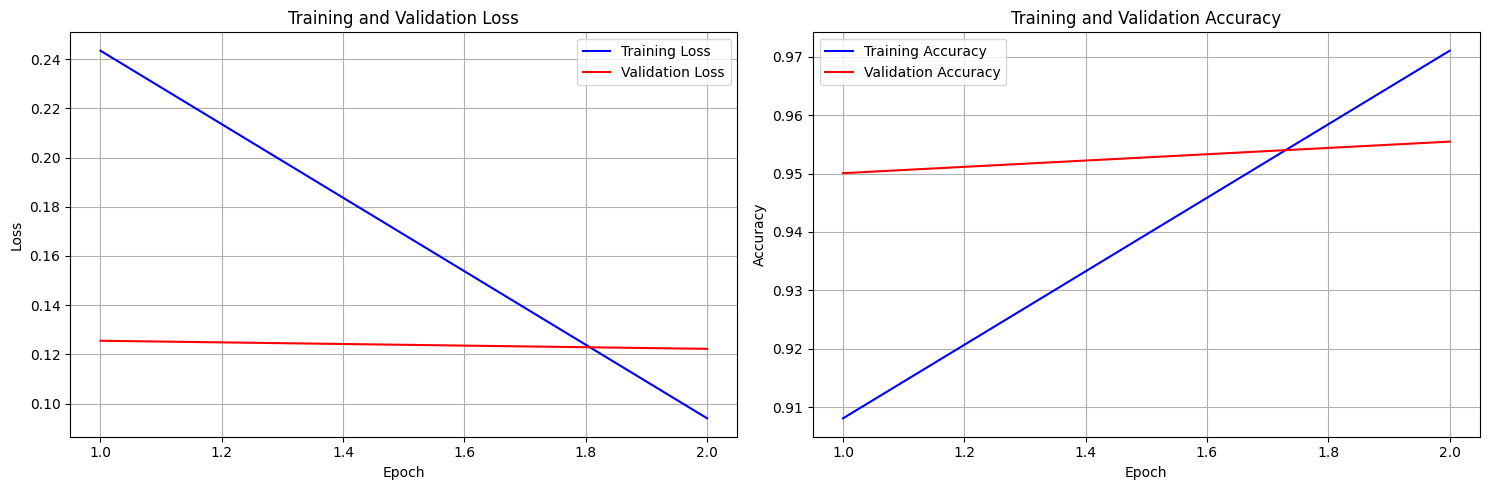

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 2}

Epoch 1/2


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2262, Accuracy: 0.9117
Validation - Loss: 0.0952, Accuracy: 0.9649

Epoch 2/2


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0973, Accuracy: 0.9673
Validation - Loss: 0.0785, Accuracy: 0.9703

Performance plots for current parameter combination:


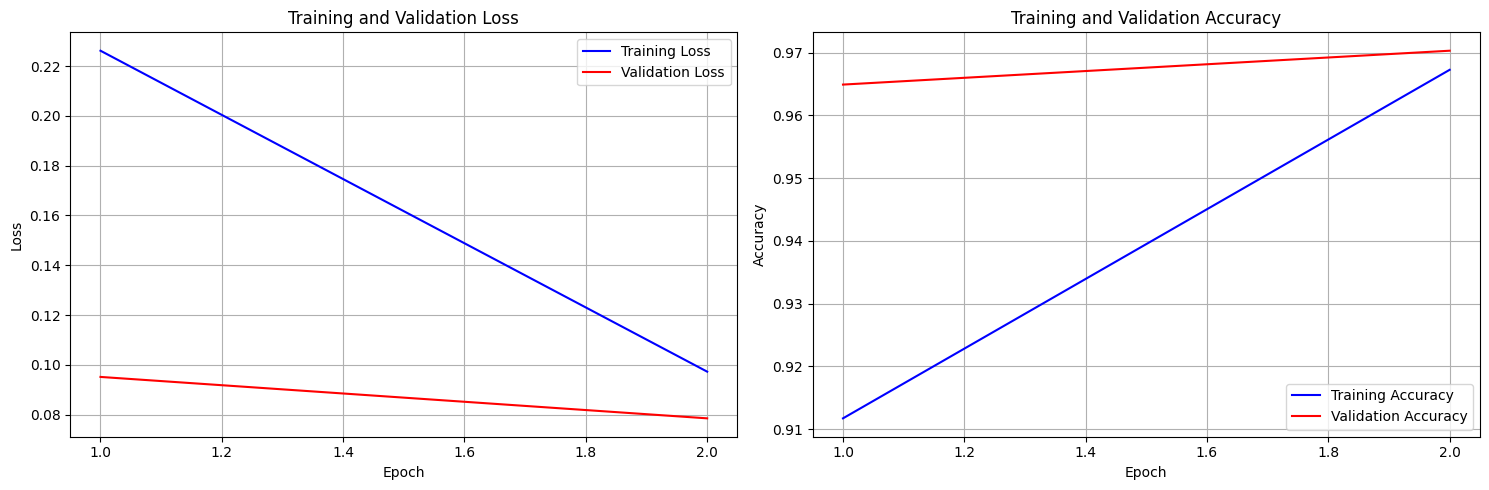

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 2}

Epoch 1/2


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2324, Accuracy: 0.9098
Validation - Loss: 0.1499, Accuracy: 0.9487

Epoch 2/2


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0884, Accuracy: 0.9688
Validation - Loss: 0.1796, Accuracy: 0.9555

Performance plots for current parameter combination:


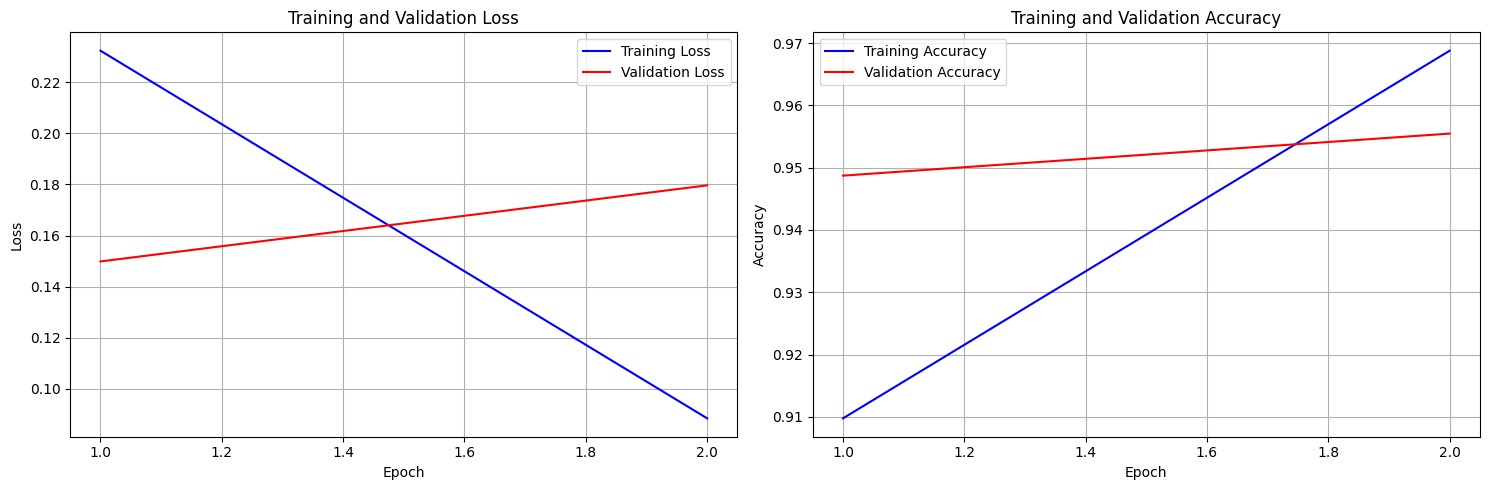

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 3}

Epoch 1/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2218, Accuracy: 0.9134
Validation - Loss: 0.1356, Accuracy: 0.9447

Epoch 2/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0930, Accuracy: 0.9689
Validation - Loss: 0.1130, Accuracy: 0.9649

Epoch 3/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0521, Accuracy: 0.9844
Validation - Loss: 0.1745, Accuracy: 0.9487

Performance plots for current parameter combination:


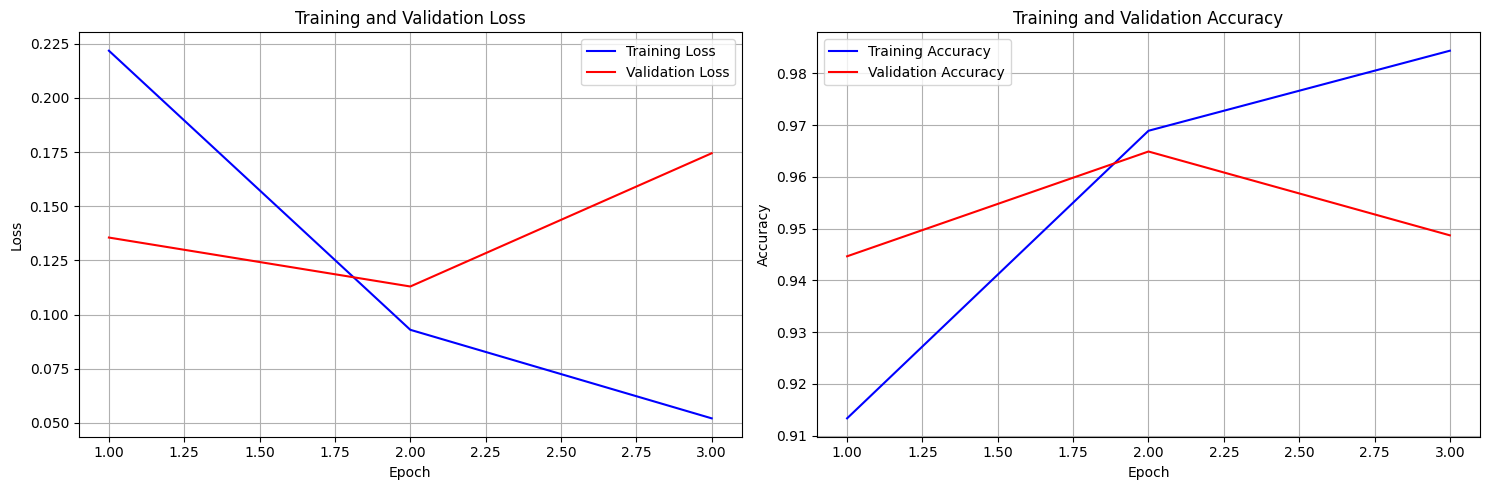

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 3}

Epoch 1/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2293, Accuracy: 0.9089
Validation - Loss: 0.1232, Accuracy: 0.9541

Epoch 2/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0952, Accuracy: 0.9689
Validation - Loss: 0.1082, Accuracy: 0.9663

Epoch 3/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0514, Accuracy: 0.9856
Validation - Loss: 0.1303, Accuracy: 0.9568

Performance plots for current parameter combination:


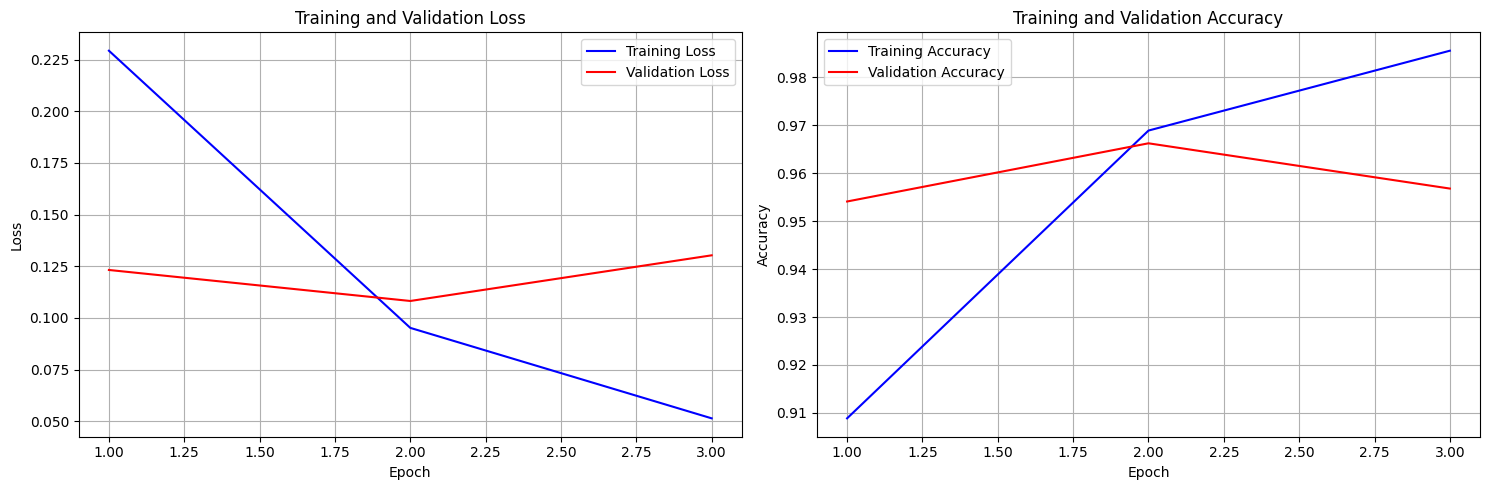

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 3}

Epoch 1/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2054, Accuracy: 0.9249
Validation - Loss: 0.1157, Accuracy: 0.9568

Epoch 2/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0855, Accuracy: 0.9725
Validation - Loss: 0.1139, Accuracy: 0.9636

Epoch 3/3


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0539, Accuracy: 0.9854
Validation - Loss: 0.1027, Accuracy: 0.9690

Performance plots for current parameter combination:


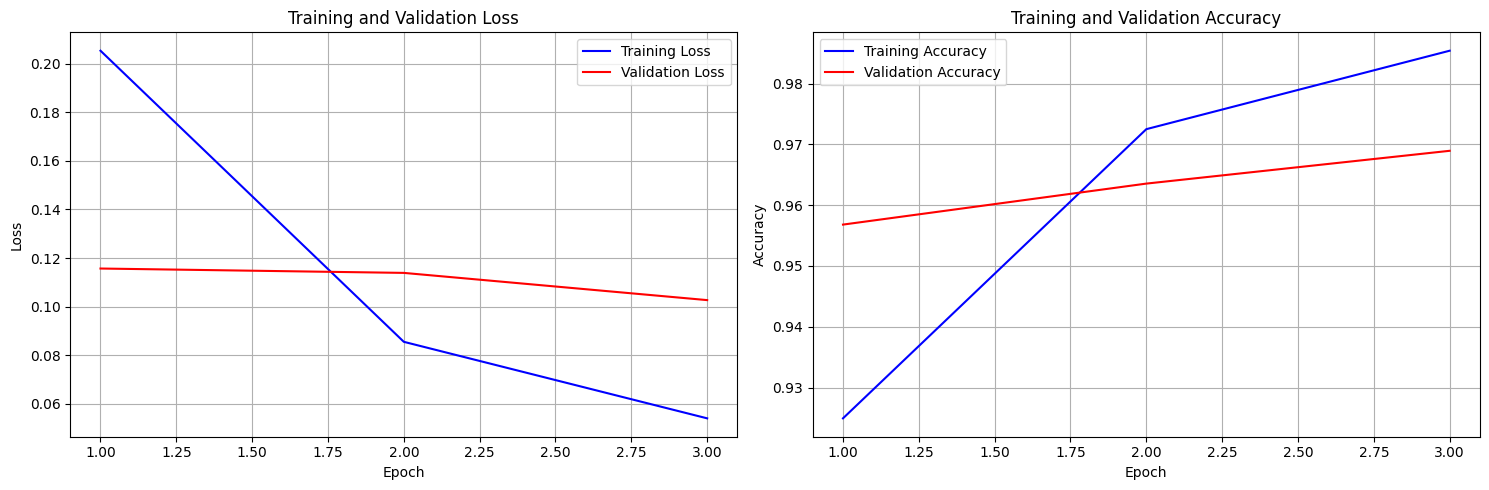

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 5}

Epoch 1/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2041, Accuracy: 0.9228
Validation - Loss: 0.1268, Accuracy: 0.9541

Epoch 2/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0874, Accuracy: 0.9701
Validation - Loss: 0.1142, Accuracy: 0.9582

Epoch 3/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0405, Accuracy: 0.9889
Validation - Loss: 0.1396, Accuracy: 0.9568

Epoch 4/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0232, Accuracy: 0.9935
Validation - Loss: 0.1585, Accuracy: 0.9582

Epoch 5/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0175, Accuracy: 0.9952
Validation - Loss: 0.1746, Accuracy: 0.9555

Performance plots for current parameter combination:


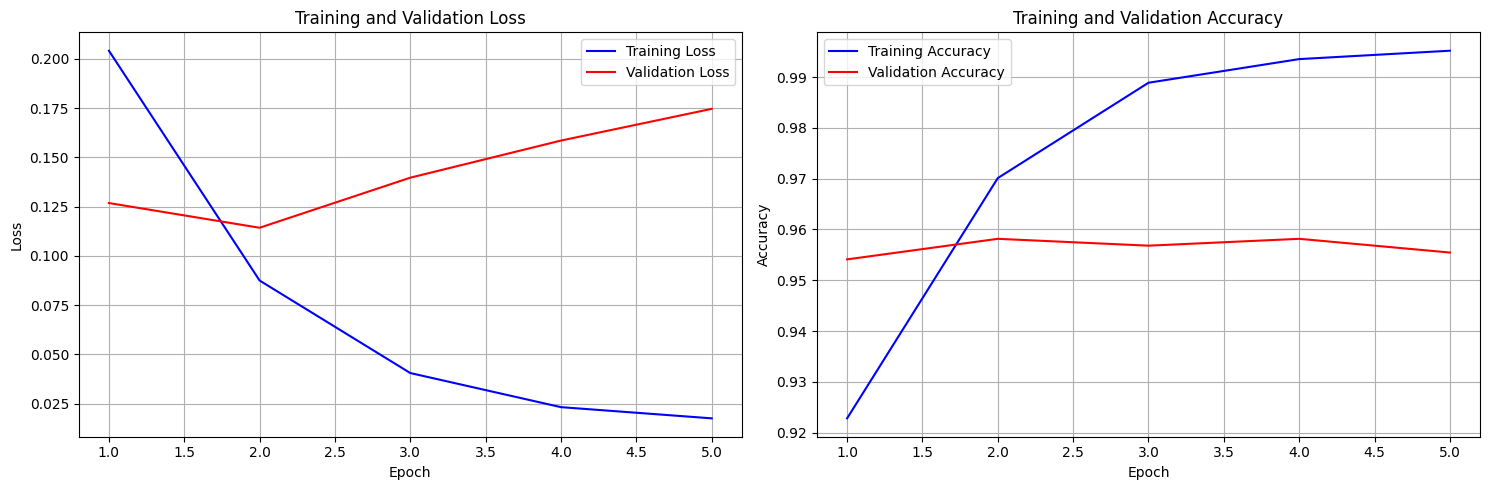

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 5}

Epoch 1/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2145, Accuracy: 0.9221
Validation - Loss: 0.1197, Accuracy: 0.9568

Epoch 2/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0964, Accuracy: 0.9682
Validation - Loss: 0.1296, Accuracy: 0.9528

Epoch 3/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0508, Accuracy: 0.9853
Validation - Loss: 0.1646, Accuracy: 0.9447

Epoch 4/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0321, Accuracy: 0.9917
Validation - Loss: 0.1713, Accuracy: 0.9582

Epoch 5/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0192, Accuracy: 0.9962
Validation - Loss: 0.1763, Accuracy: 0.9595

Performance plots for current parameter combination:


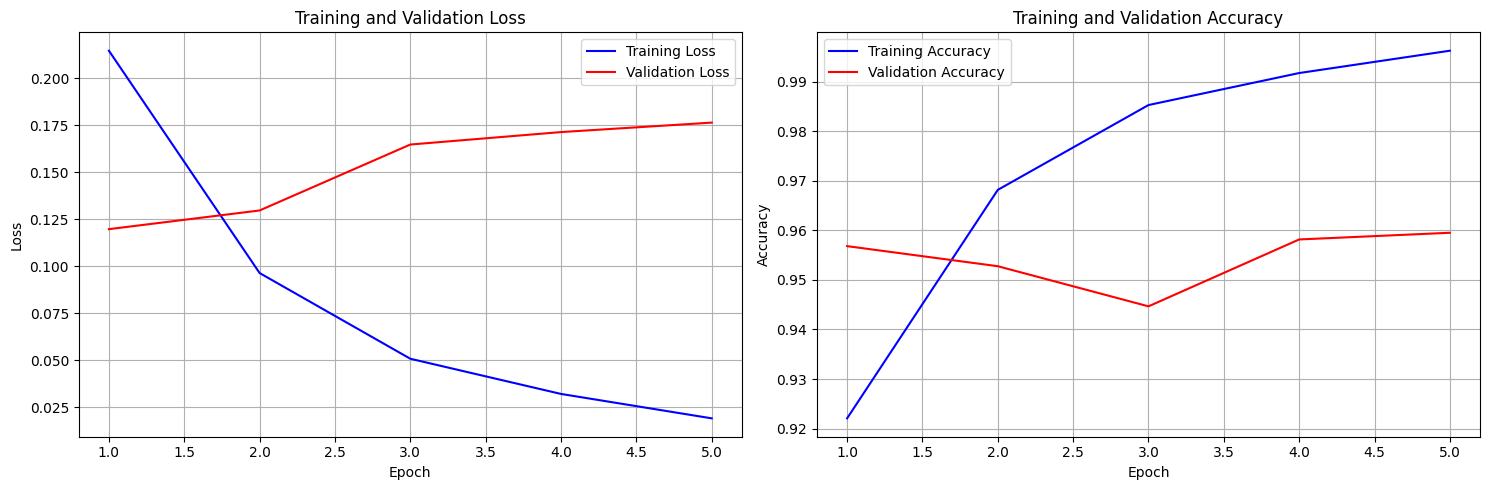

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 5}

Epoch 1/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2272, Accuracy: 0.9116
Validation - Loss: 0.1106, Accuracy: 0.9595

Epoch 2/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0861, Accuracy: 0.9736
Validation - Loss: 0.1347, Accuracy: 0.9501

Epoch 3/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0499, Accuracy: 0.9851
Validation - Loss: 0.1197, Accuracy: 0.9595

Epoch 4/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0311, Accuracy: 0.9928
Validation - Loss: 0.1206, Accuracy: 0.9555

Epoch 5/5


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0212, Accuracy: 0.9947
Validation - Loss: 0.1443, Accuracy: 0.9622

Performance plots for current parameter combination:


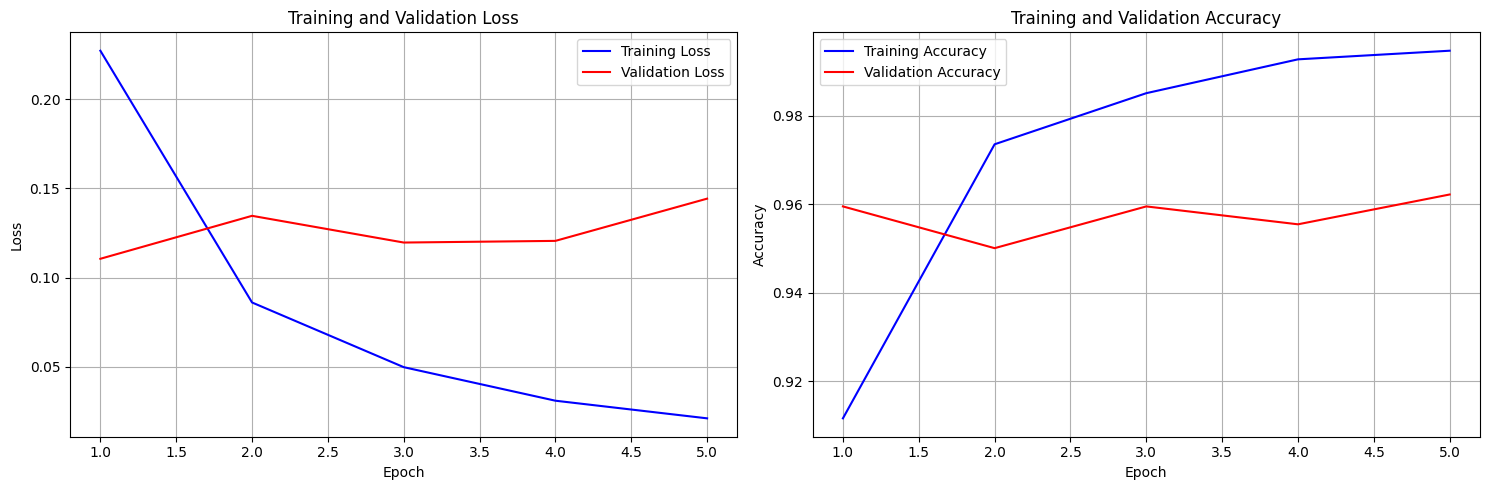

Model saved as bert_sentiment_model_ml256_bs16_lr1e-05.pt


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with parameters: {'max_length': 256, 'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 10}

Epoch 1/10


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.2306, Accuracy: 0.9093
Validation - Loss: 0.1217, Accuracy: 0.9582

Epoch 2/10


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0976, Accuracy: 0.9676
Validation - Loss: 0.1127, Accuracy: 0.9541

Epoch 3/10


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0548, Accuracy: 0.9859
Validation - Loss: 0.1348, Accuracy: 0.9555

Epoch 4/10


Training:   0%|          | 0/417 [00:00<?, ?it/s]

Training - Loss: 0.0379, Accuracy: 0.9916
Validation - Loss: 0.1264, Accuracy: 0.9595

Epoch 5/10


Training:   0%|          | 0/417 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
# Train models with different parameters
results = []
for params in parameter_combinations:
    tracker, model = train_model_with_params(params)
    results.append(tracker)
    
    # Plot metrics for this run
    print("\nPerformance plots for current parameter combination:")
    tracker.plot_metrics()
    
    # Save model if needed
    model_name = f"bert_sentiment_model_ml{params['max_length']}_bs{params['batch_size']}_lr{params['learning_rate']}.pt"
    torch.save(model.state_dict(), model_name)
    print(f"Model saved as {model_name}")

## Results Analysis

In [ ]:
# Compare results
print("\nFinal Results Comparison:")
for tracker in results:
    summary = tracker.get_summary()
    params = summary['parameters']
    print(f"\nParameters:")
    print(f"Max Length: {params['max_length']}")
    print(f"Batch Size: {params['batch_size']}")
    print(f"Learning Rate: {params['learning_rate']}")
    print(f"Number of Epochs: {params['num_epochs']}")
    print(f"Final Training Accuracy: {summary['final_train_accuracy']:.4f}")
    print(f"Final Validation Accuracy: {summary['final_val_accuracy']:.4f}")

In [ ]:
# Create comparison plot
plt.figure(figsize=(12, 6))
x = range(len(results))
train_accs = [r.get_summary()['final_train_accuracy'] for r in results]
val_accs = [r.get_summary()['final_val_accuracy'] for r in results]

width = 0.35
plt.bar([i - width/2 for i in x], train_accs, width, label='Training Accuracy')
plt.bar([i + width/2 for i in x], val_accs, width, label='Validation Accuracy')

plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, [f"Config {i+1}" for i in x])
plt.legend()
plt.grid(True)
plt.show()